### Write down the “Movie Recommendation”as a Reinforcement Learning problemformulation.Use comment lines for proper documentation.:


The problem formulation:
- State: A user's movie preferences and history of watched movies. It can also include the user's movie ratings, genres of movies the user has watched, the user's demographic information, and other relevant features
- Action: Recommend a movie to the user (a set of recommended movies or a continuous score for each movie that the algorithm scores for recommending)
- Reward: A positive reward if the recommended movie is watched and liked by the user, a negative reward otherwise
- Policy: The algorithm should learn a policy that maximizes the expected long-term reward by recommending movies that the user is likely to enjoy

### Installing, Importing required libraries

In [ ]:
!pip install tf-agents

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 KB 35.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697661 sha256=516341c5cabf5d5dff8f39ecd84535a3fba69dab2e7ecc316b1c8282703c4b3a
  Stored in directory: /root/.cache/pip/wheels/96/b9/bb/994c1324b65e39dd1cd7b8ba92e5fb766dd77980929414a866
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2


In [ ]:
!curl -o ml-100k.zip https://files.grouplens.org/datasets/movielens/ml-100k.zip && unzip ml-100k.zip 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0  6003k      0 --:--:-- --:--:-- --:--:-- 5995k
Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test       

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import functools
import os
from absl import app

import tf_agents
import tensorflow as tf  # pylint: disable=g-explicit-tensorflow-version-import
from tf_agents.bandits.agents import dropout_thompson_sampling_agent as dropout_ts_agent
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents import linear_thompson_sampling_agent as lin_ts_agent
from tf_agents.bandits.agents import neural_epsilon_greedy_agent as eps_greedy_agent
from tf_agents.bandits.agents.examples.v2 import trainer
from tf_agents.bandits.environments import environment_utilities
from tf_agents.bandits.environments import movielens_per_arm_py_environment
from tf_agents.bandits.environments import movielens_py_environment
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.bandits.networks import global_and_arm_feature_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import driver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.networks import q_network

import matplotlib.pyplot as plt
import numpy as np

### Defining variables

In [ ]:
BATCH_SIZE = 8
TRAINING_LOOPS = 1000
STEPS_PER_LOOP = 2
RANK_K = 20
NUM_ACTIONS = 20
AGENT_ALPHA = 10.0
EPSILON = 0.05
LAYERS = (50, 50, 50)
LR = 0.005
DROPOUT_RATE = 0.2

### Training the three agents

In [ ]:
tf.compat.v1.enable_v2_behavior() 

data_path = "/content/ml-100k/u.data"   

#Creating the environment  
env = movielens_py_environment.MovieLensPyEnvironment(
        data_path,
        RANK_K,
        BATCH_SIZE,
        num_movies=NUM_ACTIONS,
        csv_delimiter='\t')
environment = tf_py_environment.TFPyEnvironment(env)

optimal_reward_fn = functools.partial(
      environment_utilities.compute_optimal_reward_with_movielens_environment,
      environment=environment)

optimal_action_fn = functools.partial(
      environment_utilities.compute_optimal_action_with_movielens_environment,
      environment=environment)

In [ ]:
#Training the agent
def train(agent):

  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=BATCH_SIZE,
    max_length=STEPS_PER_LOOP)

  observers = [replay_buffer.add_batch, regret_metric]

  driver = dynamic_step_driver.DynamicStepDriver(
      env=environment,
      policy=agent.collect_policy,
      num_steps=STEPS_PER_LOOP * BATCH_SIZE,
      observers=observers)

  regret_values = []

  for _ in range(TRAINING_LOOPS):
    driver.run()
    loss_info = agent.train(replay_buffer.gather_all())
    replay_buffer.clear()
    regret_values.append(regret_metric.result())

  return regret_values, agent

###LinUCB

LinUCB


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


Text(0, 0.5, 'Average Regret')

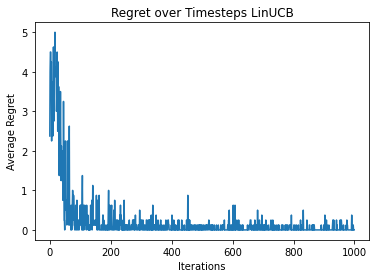

In [ ]:
print("LinUCB")
agent1 = lin_ucb_agent.LinearUCBAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        tikhonov_weight=0.001,
        alpha=AGENT_ALPHA,
        dtype=tf.float32,
        accepts_per_arm_features=False)

regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)
suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(
      optimal_action_fn)

regret_values_1, agent1 = train(agent1)
plt.plot(regret_values_1)
plt.title('Regret over Timesteps LinUCB')
plt.xlabel('Iterations')
plt.ylabel('Average Regret')

###LinTS

LinTS


Text(0, 0.5, 'Average Regret')

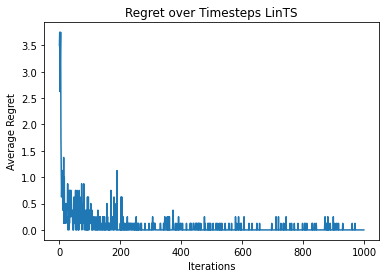

In [ ]:
print("LinTS")
agent2 = lin_ts_agent.LinearThompsonSamplingAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        dtype=tf.float32,
        accepts_per_arm_features=False)

regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)
suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(
      optimal_action_fn)

regret_values_2, agent2 = train(agent2)
plt.plot(regret_values_2)
plt.title('Regret over Timesteps LinTS')
plt.xlabel('Iterations')
plt.ylabel('Average Regret')

###NES

NeuralEpsilonGreedy


Text(0, 0.5, 'Average Regret')

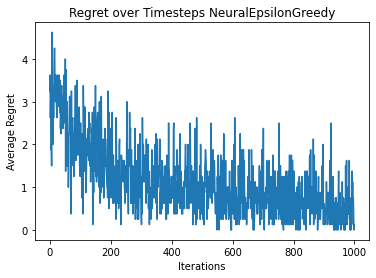

In [ ]:
print("NeuralEpsilonGreedy")
network = q_network.QNetwork(
          input_tensor_spec=environment.time_step_spec().observation,
          action_spec=environment.action_spec(),
          fc_layer_params=LAYERS)
agent3 = eps_greedy_agent.NeuralEpsilonGreedyAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        reward_network=network,
        optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
        epsilon=EPSILON,
        emit_policy_info='predicted_rewards_mean',
        info_fields_to_inherit_from_greedy=['predicted_rewards_mean'])

regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)
suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(
      optimal_action_fn)

regret_values_3, agent3 = train(agent3)
plt.plot(regret_values_3)
plt.title('Regret over Timesteps NeuralEpsilonGreedy')
plt.xlabel('Iterations')
plt.ylabel('Average Regret')

### Creating a recommendation policy and recommending on a random observation

In [ ]:
def recommendation(agent, observation):
    time_step = tf_agents.trajectories.time_step.TimeStep(
        step_type=tf.constant([[2]], dtype=tf.int32),
        reward=tf.constant([[0.0]], dtype=tf.float32),
        discount=tf.constant([[1.0]], dtype=tf.float32),
        observation=observation)
    
    action_step = agent.policy.action(time_step)
    return action_step.action.numpy()[0]

In [ ]:
observation = np.array([2, 47, 12, 7, 12, 10, 31, 4, 15, 11, 10, 20, 10, 20, 13, 14, 30, 20, 14, 21])
observation = np.expand_dims(observation, axis=0)
recommendation(agent2, observation=observation)

13